##########################################

# **MODIS TERRA NDVI AND LST TIMESERIES**

##########################################

# 1. Introduction

This notebook will guide you trough the process of requesting NDVI and LST data from the MODIS TERRA sensor and how to calculate NDVI anomalies throughout a specific time period.

Notebook outline: 

- [1. Introduction](#1.-Introduction)
- [2. Import libraries](#2.-Import-libraries)
- [3. Explore online MODIS portal](#3.-Explore-online-MODIS-portal)
- [4. Retrieve NDVI](#4.-Retrieve-NDVI)
- [5. Plot timeseries](#5.-Plot-timeseries)
- [6. Calculate anomaly](#6.-Calculate-anomaly)
- [7. Plot anomaly](#7.-Plot-anomaly)
- [8. Land surface temperature](#8-land-surface-temperature)

# 2. Import libraries 

In this notebook we are going to request data from NASA's MODIS TERRA mission using the following url:
"https://modis.ornl.gov/rst/api/v1/"

To request the data and preprocess the data the following packages are needed:

In [1]:
import requests
from pathlib import Path
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# url information for modis online portal 
url = "https://modis.ornl.gov/rst/api/v1/"
header = {'Accept': 'application/json'}
# NOTE: Use following for a csv response:
# header = {'Accept': 'text/csv'}

# 3. Explore online MODIS portal

An online portal usually consists of multiple layers: product, bands, dates...
In order to retrieve relevant information, we need to explore which products are available.
A request is made to get an overview of the products:

In [2]:
# Request the products available on the online portal
response = requests.get('https://modis.ornl.gov/rst/api/v1/products?', headers=header)
products = json.loads(response.text)['products']

# convert response body to DataFrame object
workspaces = pd.DataFrame.from_dict(products) 
workspaces

,product,description,frequency,resolution_meters
0,Daymet,Daily Surface Weather Data (Daymet) on a 1-km ...,Daily,1000
1,ECO4ESIPTJPL,ECOSTRESS Evaporative Stress Index PT-JPL (ESI...,Varies,70
2,ECO4WUE,ECOSTRESS Water Use Efficiency (WUE) Daily L4 ...,Varies,70
3,GEDI03,GEDI Gridded Land Surface Metrics (LSM) L3 1km...,One-time,1000
4,GEDI04_B,GEDI Gridded Aboveground Biomass Density (AGBD...,One-time,1000
5,MCD12Q1,MODIS/Terra+Aqua Land Cover Type (LC) Yearly L...,Yearly,500
6,MCD12Q2,MODIS/Terra+Aqua Land Cover Dynamics (LCD) Yea...,Yearly,500
7,MCD15A2H,MODIS/Terra+Aqua Leaf Area Index/FPAR (LAI/FPA...,8-Day,500
8,MCD15A3H,MODIS/Terra+Aqua Leaf Area Index/FPAR (LAI/FPA...,4-Day,500
9,MCD19A3,MODIS/Terra+Aqua BRDF Model Parameters (MAIAC)...,8-Day,1000


As we are interested in the NDVI, choose the product which holds information about vegetation indices and explore which bands are available by making a second request:

In [3]:
product = 'MOD13Q1'
response = requests.get(f'https://modis.ornl.gov/rst/api/v1/{product}/bands?', headers=header)
bands = json.loads(response.text)['bands']

# convert response body to DataFrame object
modis_bands = pd.DataFrame.from_dict(bands) 
modis_bands

,band,description,units,valid_range,fill_value,scale_factor,add_offset
0,250m_16_days_blue_reflectance,Surface Reflectance Band 3,reflectance,0 to 10000,-1000,0.0001,0
1,250m_16_days_composite_day_of_the_year,Day of year VI pixel,Julian day of the year,1 to 366,-1,NaN,NaN
2,250m_16_days_EVI,16 day EVI average,EVI ratio - No units,-2000 to 10000,-3000,0.0001,0
3,250m_16_days_MIR_reflectance,Surface Reflectance Band 7,reflectance,0 to 10000,-1000,0.0001,0
4,250m_16_days_NDVI,16 day NDVI average,NDVI ratio - No units,-2000 to 10000,-3000,0.0001,0
5,250m_16_days_NIR_reflectance,Surface Reflectance Band 2,reflectance,0 to 10000,-1000,0.0001,0
6,250m_16_days_pixel_reliability,Quality reliability of VI pixel,rank,0 to 3,-1,NaN,NaN
7,250m_16_days_red_reflectance,Surface Reflectance Band 1,reflectance,0 to 10000,-1000,0.0001,0
8,250m_16_days_relative_azimuth_angle,Relative azimuth angle of VI pixel,degrees,-3600 to 3600,-4000,0.1,0
9,250m_16_days_sun_zenith_angle,Sun zenith angle of VI pixel,degrees,-9000 to 9000,-10000,0.01,0


In [4]:
# Note the attributes in the table above. We save both the scale factor and no data value for later use...
nodata = float(modis_bands.fill_value[modis_bands.band == '250m_16_days_NDVI'])
scale = float(modis_bands.scale_factor[modis_bands.band == '250m_16_days_NDVI'])

We want to create a timeseries. Therefore it is useful to know at which timesteps the NDVI is available for a certain location:

In [5]:
product = 'MOD13Q1'
band = '250m_16_days_NDVI'
lat = str(10.690)
lon = str(40.766)
response = requests.get(f'https://modis.ornl.gov/rst/api/v1/{product}/dates?band={band}&latitude={lat}&longitude={lon}', headers=header)
dates = json.loads(response.text)['dates']

modis_dates = [i['modis_date'] for i in dates]
calendar_dates = [i['calendar_date'] for i in dates]
print(f'First day: {calendar_dates[0]}, Last day: {calendar_dates[-1]}')

First day: 2000-02-18, Last day: 2022-07-12


This Modis portal offers more than Vegetation indices. Have a look at for example the land surface temperature 'MOD11A2'

In [6]:
product = 'MOD11A2' # 'MOD21A2' # 'MOD11A2' 
response = requests.get(f'https://modis.ornl.gov/rst/api/v1/{product}/bands?', headers=header)
bands = json.loads(response.text)['bands']
# convert response body to DataFrame object
modis_bands = pd.DataFrame.from_dict(bands) 
modis_bands

# note there is both a day- and nighttime obervation available!

,band,description,valid_range,fill_value,units,scale_factor,add_offset
0,Clear_sky_days,Day clear-sky coverage,1 to 255,0,NaN,NaN,NaN
1,Clear_sky_nights,Night clear-sky coverage,1 to 255,0,NaN,NaN,NaN
2,Day_view_angl,View zenith angle of day observation,0 to 130,255,degree,1,-65
3,Day_view_time,Local time of day observation,0 to 240,255,hrs,0.1,0
4,Emis_31,Band 31 emissivity,1 to 255,0,NaN,0.002,0.49
5,Emis_32,Band 32 emissivity,1 to 255,0,NaN,0.002,0.49
6,LST_Day_1km,Daytime Land Surface Temperature,7500 to 65535,0,Kelvin,0.02,0
7,LST_Night_1km,Night Land Surface Temperature,7500 to 65535,0,Kelvin,0.02,0
8,Night_view_angl,View zenith angle of night observation,0 to 130,255,degree,1,-65
9,Night_view_time,Local time of night observation,0 to 240,255,hrs,0.1,0


# 4. Retrieve NDVI

As we are only interested in a small area and/or a specific time period, the data will be requested throught the subset module. This subset module only allows for 10 extractions. If you want a timeseries exceeding 10 instances, a for loop should be created, looping over the (modis)dates of interest:

In [7]:
# If you are interested in only a specific time period, you can make a subset of the modis dates. E.g., the following line takes the last 20 timesteps.
dates_subset = modis_dates[-20:]
# dates_subset = modis_dates

Now let's have a look at how to download the timeseries from modis, for our specific point.

Depending on your PC's capabilities, the following cell may take around 20 minutes to run...
Unless you want to alter the timeperiod or location, you can skip the cell as the corresponding NDVI timeseries is already available as a csv in the /data folder.

In [11]:
# Initialize lists to store the data
data_ndvi = []
product = 'MOD13Q1'
band = '250m_16_days_NDVI'
lat = 10.690
lon = 40.766
# the following 2 parameters could be used to extract more than one pixel. Note that the request will take much longer then!
above_below = 0  # km above and below pixel
left_right = 0 # km above and below pixel

# Iterate through the list of dates and submit subset requests for each date:
for dt in dates_subset:
    
    # Join request parameters to URL string and submit request
    ndvi_response = requests.get("".join([
        url, product, "/subset?",
        "latitude=", str(lat),
        "&longitude=", str(lon),
        "&band=", band,
        "&startDate=", dt,
        "&endDate=", dt,
        "&kmAboveBelow=", str(above_below),
        "&kmLeftRight=", str(left_right)
    ]), headers=header)

    # Append subset data to final result
    data_ndvi.append( json.loads(ndvi_response.text)['subset'][0]['data'] )

# Convert the data into a dataframe for easier processing.
# As an index we use the converted datetime (Modis to real datetime format).
dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates_subset]
dates_dt = pd.to_datetime(dates)

# make dataframe of the NDVI values with date as index
data_ndvi = pd.DataFrame(data_ndvi, index=dates_dt)
# give the column a name
data_ndvi.columns = ['NDVI']
# replace nodata value by NaN
data_ndvi = data_ndvi.replace(nodata, np.nan)
# multiply the NDVI values with the scale factor
data_ndvi.NDVI = data_ndvi.NDVI * scale 

# export to .csv file in a new "downloads" folder
outfile = './downloads/ndvi_timeseries.csv'
Path(outfile).parent.mkdir(exist_ok=True, parents=True)
data_ndvi.to_csv(outfile, index_label='date')

Import the NDVI timeseries that was already downloaded for you:

In [9]:
infile = './data/ndvi_timeseries.csv'
data_ndvi = pd.read_csv(infile, parse_dates=['date'], index_col=['date'])
# visualize resulting dataframe:
data_ndvi.head()

,NDVI
date,
2000-02-19,0.1348
2000-03-06,0.1294
2000-03-22,0.1361
2000-04-07,0.1399
2000-04-23,0.1369


# 5. Plot timeseries

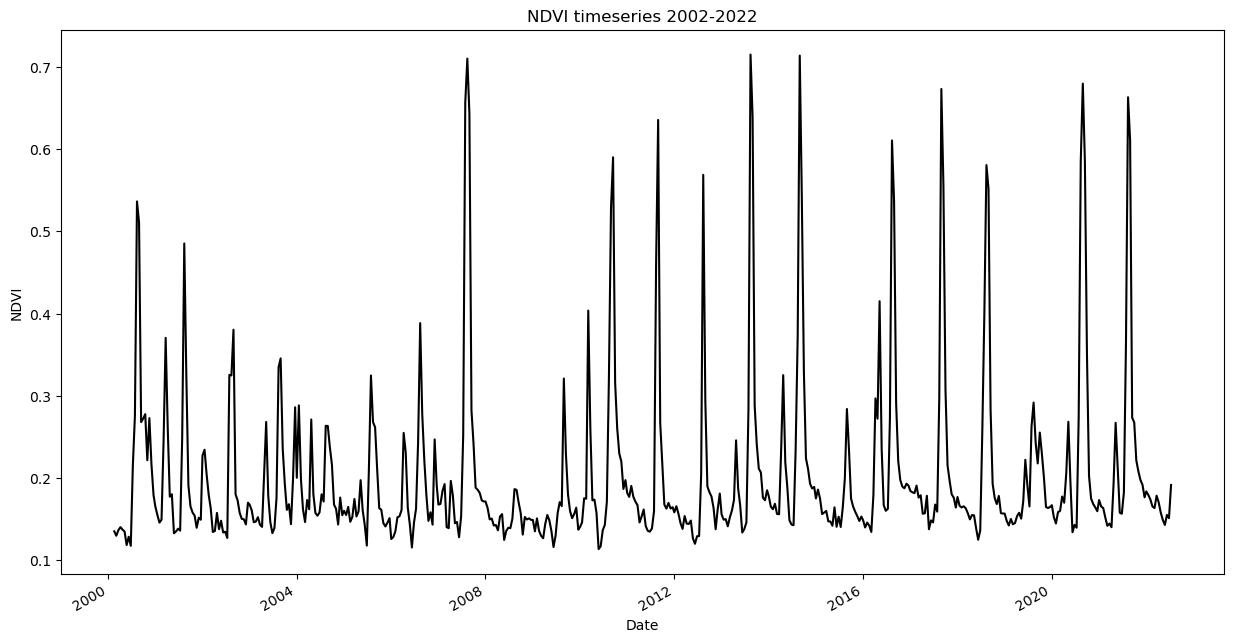

In [10]:
plt.rcParams['figure.figsize'] = (15,8)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('NDVI')
ax1.plot(data_ndvi.index, data_ndvi.NDVI, 'k-')
ax1.tick_params(axis='y')
ax1.set_title('NDVI timeseries 2002-2022')
fig.autofmt_xdate()

plt.show()

# 6. Calculate anomaly

In order to create monthly standardized anomalies, NDVI is averaged over each month and compared with other years. The theory can be found in ppt 6.2_2 slide 26.
First we need to convert our data frame to monthly averages. As our index has a datetime format wa can easily select all the NDVI values from one month using the following command:

In [11]:
# For example: NDVI values for November 2013:
data_ndvi.loc['2013-11']

,NDVI
date,
2013-11-02,0.2065
2013-11-18,0.1757


Calculate the mean NDVI over each month, to get a monthly timeseries

In [12]:
NDVI_monthly = data_ndvi.resample('M').mean()
NDVI_monthly.index = pd.to_datetime(NDVI_monthly.index)
NDVI_monthly['month'] = [datetime.datetime.strftime(date, '%m') for date in NDVI_monthly.index]
NDVI_monthly.head()

,NDVI,month
date,,
2000-02-29,0.13480,02
2000-03-31,0.13275,03
2000-04-30,0.13840,04
2000-05-31,0.12625,05
2000-06-30,0.12265,06


Keep only one instance of each month and calculate the mean and standard deviation for each month

In [13]:
months = NDVI_monthly.month.drop_duplicates()
mean = []
std = []

for month in months:
    mean.append(np.mean(NDVI_monthly.NDVI[NDVI_monthly.month == month]))
    std.append(np.std(NDVI_monthly.NDVI[NDVI_monthly.month == month]))

NDVI_month_stat = pd.DataFrame()
NDVI_month_stat['month'] = months
NDVI_month_stat['NDVI_mean'] = mean
NDVI_month_stat['NDVI_std'] = std
NDVI_month_stat

,month,NDVI_mean,NDVI_std
date,,,
2000-02-29,02,0.160083,0.016608
2000-03-31,03,0.167902,0.048615
2000-04-30,04,0.180000,0.041746
2000-05-31,05,0.171235,0.044933
2000-06-30,06,0.141530,0.017609
2000-07-31,07,0.210907,0.068681
2000-08-31,08,0.437234,0.153607
2000-09-30,09,0.289518,0.123821
2000-10-31,10,0.202268,0.043924


Create a function to calculate the anomaly:

In [14]:
# anomaly 
def anomaly(value, month, stats, mean_col='NDVI_mean', std_col='NDVI_std'):
    
    mean = stats.loc[stats['month']==month, mean_col].values[0]
    std = stats.loc[stats['month']==month, std_col].values[0]
    result = (value - mean) / std
    
    return result

In [15]:
anomaly_list = []

for l in range(len(NDVI_monthly)):
    anomaly_list.append(anomaly(NDVI_monthly.NDVI[l], NDVI_monthly.month[l], NDVI_month_stat))

NDVI_anom = NDVI_monthly.copy()
NDVI_anom['NDVI_anom'] = anomaly_list
NDVI_anom.head()


,NDVI,month,NDVI_anom
date,,,
2000-02-29,0.13480,02,-1.522315
2000-03-31,0.13275,03,-0.723077
2000-04-30,0.13840,04,-0.996500
2000-05-31,0.12625,05,-1.001148
2000-06-30,0.12265,06,-1.072208


# 7. Plot anomaly

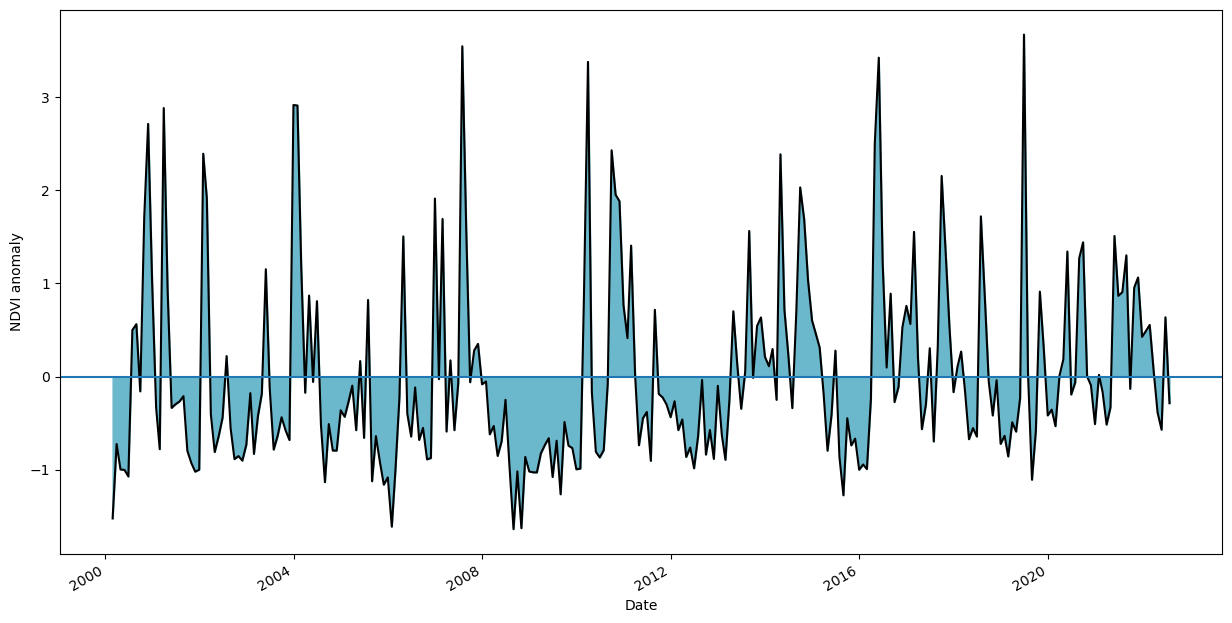

In [16]:
plt.rcParams['figure.figsize'] = (15,8)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('NDVI anomaly')
ax1.plot(NDVI_anom.index, NDVI_anom.NDVI_anom, 'k-')
ax1.tick_params(axis='y')
ax1.axhline(y=0)
ax1.fill_between(NDVI_anom.index, NDVI_anom.NDVI_anom, color = '#6bb8cc')
fig.autofmt_xdate()

plt.show()

# 8. Land surface temperature

Let's have a look at how we can download the LST for a specific point:

In [17]:
product = 'MOD11A2' 
response = requests.get(f'https://modis.ornl.gov/rst/api/v1/{product}/bands?', headers=header)
bands = json.loads(response.text)['bands']
bands

# convert response body to DataFrame object
modis_bands = pd.DataFrame.from_dict(bands)
# save scale factor and no data value for later use
scale = float(modis_bands.scale_factor[modis_bands.band == 'LST_Day_1km'])
nodata = float(modis_bands.fill_value[modis_bands.band == 'LST_Day_1km'])
modis_bands

,band,description,valid_range,fill_value,units,scale_factor,add_offset
0,Clear_sky_days,Day clear-sky coverage,1 to 255,0,NaN,NaN,NaN
1,Clear_sky_nights,Night clear-sky coverage,1 to 255,0,NaN,NaN,NaN
2,Day_view_angl,View zenith angle of day observation,0 to 130,255,degree,1,-65
3,Day_view_time,Local time of day observation,0 to 240,255,hrs,0.1,0
4,Emis_31,Band 31 emissivity,1 to 255,0,NaN,0.002,0.49
5,Emis_32,Band 32 emissivity,1 to 255,0,NaN,0.002,0.49
6,LST_Day_1km,Daytime Land Surface Temperature,7500 to 65535,0,Kelvin,0.02,0
7,LST_Night_1km,Night Land Surface Temperature,7500 to 65535,0,Kelvin,0.02,0
8,Night_view_angl,View zenith angle of night observation,0 to 130,255,degree,1,-65
9,Night_view_time,Local time of night observation,0 to 240,255,hrs,0.1,0


In [18]:
# check product availability in time:
product = 'MOD11A2'
band = 'LST_Day_1km'
lat = 10.690
lon = 40.766
response = requests.get(f'https://modis.ornl.gov/rst/api/v1/{product}/dates?band={band}&latitude={lat}&longitude={lon}', headers=header)
dates = json.loads(response.text)['dates']

modis_dates = [i['modis_date'] for i in dates]
calendar_dates = [i['calendar_date'] for i in dates]
print(f'First day: {calendar_dates[0]}, Last day: {calendar_dates[-1]}')

First day: 2000-02-18, Last day: 2022-08-21


In [19]:
# If you are interested in only a specific timeperiod, you can make a subset of the modis dates. E.g., the following line takes the last 20 timesteps
dates_subset = modis_dates[-20:]
# dates_subset = modis_dates

Depending on your PC's capabilities, the following cell may take around 20 minutes to run... Unless you want to alter the time period or location, the following cell can be skipped as the corresponding LST timeseries is already available as a csv in the /data folder.

In [22]:
# Initialize lists to store the data
data_LST = []
product = 'MOD11A2'
band = 'LST_Day_1km'
lat = 10.690
lon = 40.766
above_below = 0  # km above and below pixel
left_right = 0 # km above and below pixel

# Iterate through the list of dates and submit subset requests for each date:
for dt in dates_subset:
    
    # Join request parameters to URL string and submit request
    lst_response = requests.get("".join([
        url, product, "/subset?",
        "latitude=", str(lat),
        "&longitude=", str(lon),
        "&band=", band,
        "&startDate=", dt,
        "&endDate=", dt,
        "&kmAboveBelow=", str(above_below),
        "&kmLeftRight=", str(left_right)
    ]), headers=header)

    # Append subset data to lstdata
    data_LST.append( json.loads(lst_response.text)['subset'][0]['data'] )
    
dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates_subset]
dates_dt = pd.to_datetime(dates)

# make data frame of the LST values with date as index
data_LST = pd.DataFrame(data_LST, index=dates_dt)
data_LST.columns = ['LST']
data_LST['LST'] = data_LST['LST'].astype(float)
# replace nodata values by NaN
data_LST = data_LST.replace(nodata, np.nan)
# multiply by scale factor
data_LST['LST'] = data_LST['LST'] * scale

# export to .csv file in a new "downloads" folder
outfile = './downloads/lst_timeseries.csv'
Path(outfile).parent.mkdir(exist_ok=True, parents=True)
data_LST.to_csv(outfile, index_label='date')

Import the LST timeseries that was already downloaded for you:

In [24]:
infile = './data/lst_timeseries.csv'
data_LST = pd.read_csv(infile, parse_dates=['date'], index_col=['date'])
data_LST.head()

,LST
date,
2000-02-19,NaN
2000-02-27,317.88
2000-03-06,318.48
2000-03-14,320.96
2000-03-22,320.50


Text(0.5, 1.0, 'LST in Kelvin every 8 days')

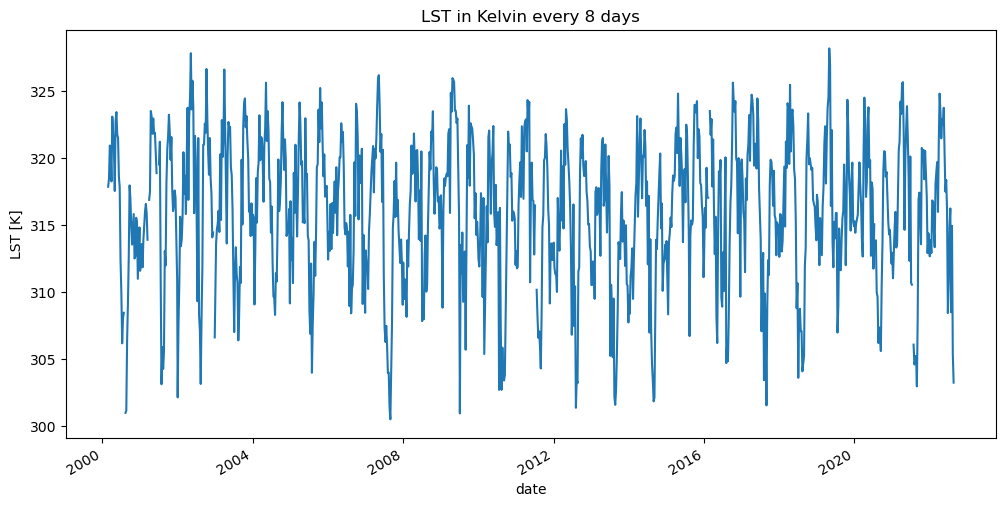

In [25]:
figs, ax = plt.subplots(1, figsize=(12, 6))
data_LST['LST'].plot(ax=ax, label='LST in K')

ax.set_ylabel('LST [K]')
ax.set_title('LST in Kelvin every 8 days')